# <b>AASD 4015 - Advance Mathematical Concepts for Deep Learning Group Project 2</b>

<b>Members:</b> 
1. Saksham Prakash (101410709) 
2. Sik Yin Sun (101409665)

## Background and Motivation

## <b> 1. Installing and Importing libraries </b>
<a id='lib'></a>

In [2]:
!pip install tensorflow-addons vit-keras typing_extensions typeguard seaborn scikit-learn seaborn opencv-python kaggle imbalanced-learn

In [3]:
import os
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, inception_v3, efficientnet_v2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from vit_keras import vit

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-04-06 09:30:40.673424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 09:30:41.676439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cud

In [4]:
def plot_accuracy_and_loss(history):
    fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

    ax[0].plot(history.history['accuracy'], label="Train accuracy")
    ax[0].plot(history.history['val_accuracy'], label="Validation accuracy")
    ax[0].set_title("Model accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("accuracy")
    ax[0].legend(["train", "val"])
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(history.history['loss'], label="Train loss")
    ax[1].plot(history.history['val_loss'], label="Validation loss")
    ax[1].set_title("Model loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("loss")
    ax[1].legend(["train", "val"])
    ax[1].grid(True)
    ax[1].legend()

    plt.show()

def print_confusion_matrix(y_true, y_pred):
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def print_classification_report(y_true, y_pred, class_names):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

def evaluate_model(model, train_dataset, val_dataset, test_dataset, epochs=10, class_names=None):
    
    # Train the model
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)
    
    # Model summary
    print("\nModel Summary:")
    model.summary()

    # Plot training and loss plots
    plot_accuracy_and_loss(history)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"\nTest accuracy: {test_accuracy}")
    
    # Confusion Matrix and Classification Report
    y_true = np.concatenate([y for _, y in test_dataset], axis=0)
    y_pred = np.squeeze(np.round(model.predict(test_dataset)))

    print_confusion_matrix(y_true, y_pred)
    print_classification_report(y_true, y_pred, class_names)

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-04-06 09:30:43.495042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 09:30:43.541291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 09:30:43.541557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## <b>2. Data</b>
<font size=3>The link of Data:</font>
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

### 2.1 Download

In [27]:
os.environ['KAGGLE_CONFIG_DIR'] = "."
if not os.path.exists('chest_xray'):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip

In [7]:
train_dir = os.path.join('.','chest_xray','train')
val_dir = os.path.join('.','chest_xray','val')
test_dir = os.path.join('.','chest_xray','test')

In [8]:
img_height = 320
img_width = 320
batch_size = 16
seed = 9876

### 2.2 Initial Exploration

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True, seed=seed)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True, seed=seed)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True, seed=seed)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2023-04-06 09:31:45.489744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 09:31:45.490374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 09:31:45.490660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 09:31:45.490868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [10]:
class_label = train_data.class_names
train_num = []
val_num = []
test_num = []
print("Train Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(train_dir, i)))
    train_num.append(num_files)
    print(f"{i}: {num_files} files")

print("\nValidation Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(val_dir, i)))
    val_num.append(num_files)
    print(f"{i}: {num_files} files")

print("\nTest Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(test_dir, i)))
    test_num.append(num_files)
    print(f"{i}: {num_files} files")

Train Data
NORMAL: 1341 files
PNEUMONIA: 3875 files

Validation Data
NORMAL: 8 files
PNEUMONIA: 8 files

Test Data
NORMAL: 234 files
PNEUMONIA: 390 files


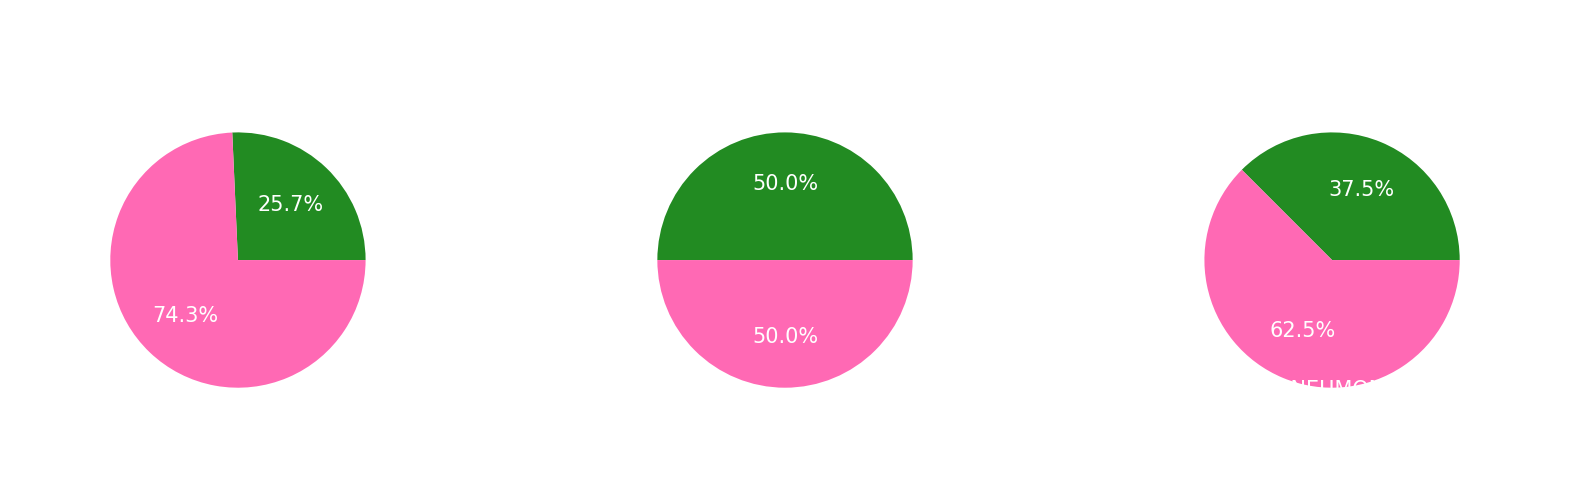

In [11]:
colors = ['#228b22', '#ff69b4']
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
axs[0].pie(train_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[0].set_title('Distribution of Images Across Classes for Train Data', color="white")
axs[1].pie(val_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[1].set_title('Distribution of Images Across Classes for Validation Data', color="white")
axs[2].pie(test_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[2].set_title('Distribution of Images Across Classes for Test Data', color="white")
plt.show()

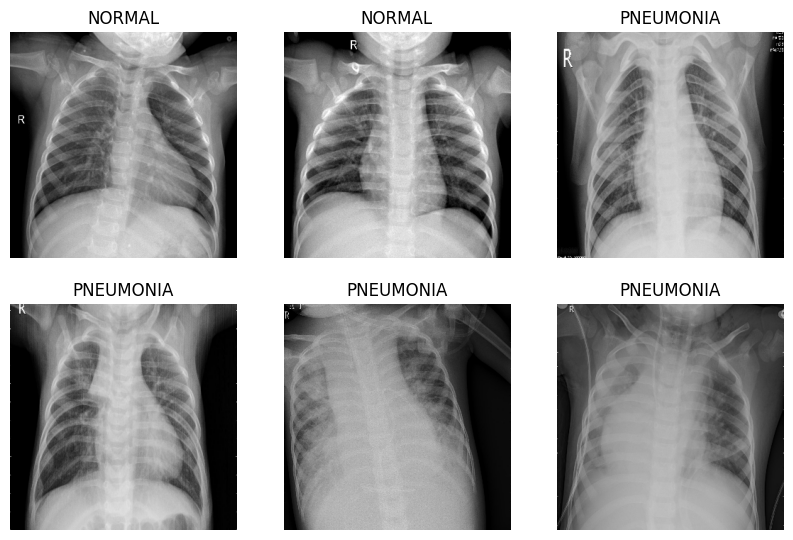

In [12]:
plt.figure(figsize = (10,10))
for images, labels in train_data.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_label[labels[i]])
    plt.axis('off')

### 2.3 Handling imbalance in dataset

In [13]:
def load_images_from_directory(dir_path, class_names, target_size=(320, 320)):
    images = []
    labels = []
    for class_name in class_names:
        class_dir = os.path.join(dir_path, class_name)
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_names.index(class_name))
    return np.array(images), np.array(labels)

def get_balanced_train_data(train_dir, class_names, img_height, img_width):
    X, y = load_images_from_directory(train_dir, class_names, target_size=(img_height, img_width))
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X.reshape(X.shape[0], -1), y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], img_height, img_width, 3)
    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)
    return X_resampled, y_resampled

def create_dataset(X, y, batch_size=16):
    X = X.astype('float32') / 255.0 
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [14]:
X, y = get_balanced_train_data(train_dir, class_label, img_height, img_width)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
train_data = create_dataset(X_train, y_train, batch_size=16)
val_data = create_dataset(X_val, y_val, batch_size=16)

2023-04-06 09:32:59.120317: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7618560000 exceeds 10% of free system memory.
2023-04-06 09:33:06.362107: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7618560000 exceeds 10% of free system memory.


In [15]:
test_dataset = test_data.map(lambda x, y: (x / 255.0, y)).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<font size=3>After briefly exploring the data, we found out that there is a vast difference between "normal" and "pneumonia" for the train data. Additionally, we found that there is more pneumonia record than normal. From the image above, we can see them for people with pneumonia. Their X-ray pictures are much blurry than normal people, and we believe that is because the lung infection causes some fluid there.</font>

In [17]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array([0, 1]), array([3110, 3090]))
(array([0, 1]), array([765, 785]))


## <b> 3. Training baseline backbone architectures with simple head </b>

### 3.1 VGG-16

In [18]:
image_size = (img_height, img_width,3) 
vgg16 = VGG16(include_top = False, weights = 'imagenet',input_shape = image_size)

for layer in vgg16.layers:
    layer.trainable = False
    
x = Flatten()(vgg16.output)
x = Dense(1, activation="sigmoid")(x)

vgg16 = Model(inputs=vgg16.input, outputs=x)
vgg16.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

2023-04-06 09:34:22.816751: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 7618560000 exceeds 10% of free system memory.


Epoch 1/10


2023-04-06 09:34:32.951854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-04-06 09:34:34.361617: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fdb152df130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-06 09:34:34.361664: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-04-06 09:34:34.368664: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-06 09:34:34.518014: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 [==============================] - 26s 59ms/step - loss: 0.1015 - accuracy: 0.9616 - val_loss: 0.0444 - val_accuracy: 0.9839
Epoch 2/10
388/388 [==============================] - 19s 50ms/step - loss: 0.0273 - accuracy: 0.9908 - val_loss: 0.0271 - val_accuracy: 0.9929
Epoch 3/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.0224 - val_accuracy: 0.9942
Epoch 4/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.0197 - val_accuracy: 0.9961
Epoch 5/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0169 - val_accuracy: 0.9968
Epoch 6/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.0226 - val_accuracy: 0.9948
Epoch 7/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9968
Epo

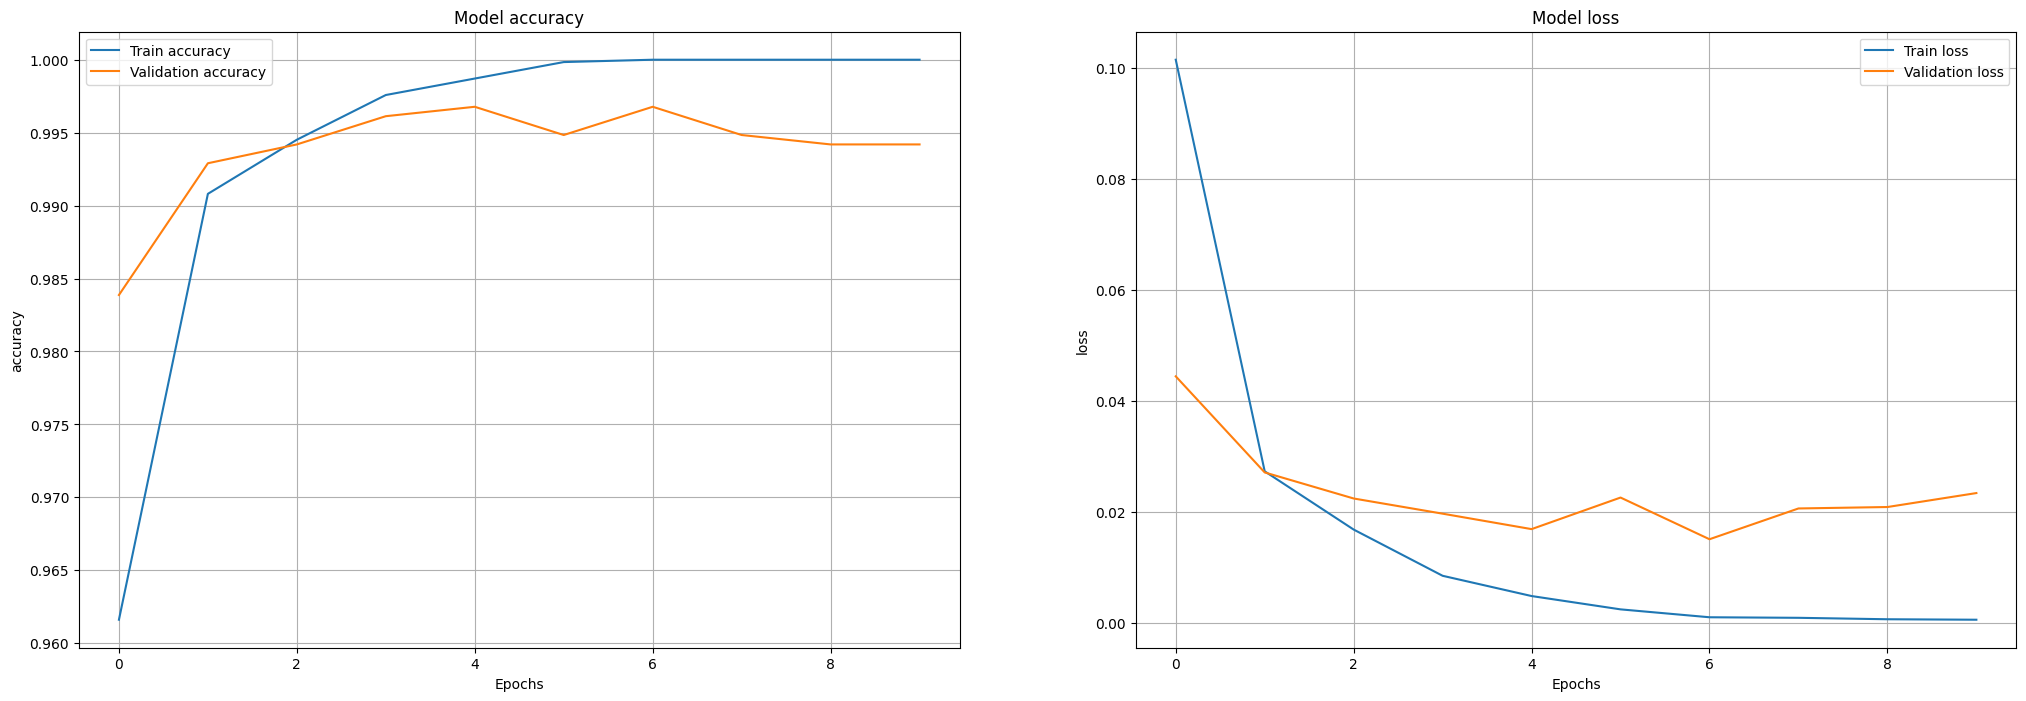

39/39 [==============================] - 2s 41ms/step - loss: 59.2492 - accuracy: 0.7035

Test accuracy: 0.7035256624221802
39/39 [==============================] - 2s 39ms/step

Confusion Matrix:


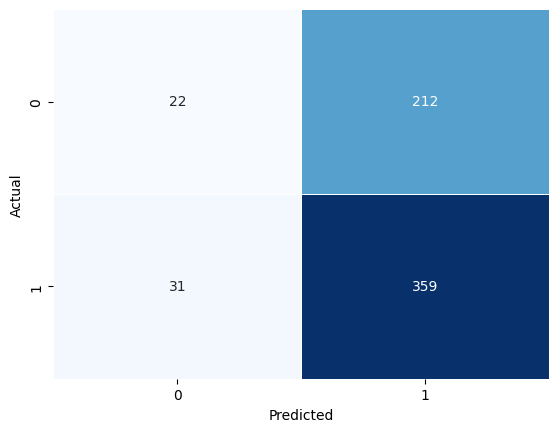


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.42      0.09      0.15       234
   PNEUMONIA       0.63      0.92      0.75       390

    accuracy                           0.61       624
   macro avg       0.52      0.51      0.45       624
weighted avg       0.55      0.61      0.52       624



In [19]:
evaluate_model(model=vgg16, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10, class_names=class_label)

### 3.2 InceptionV3 

In [24]:
iv3 = inception_v3.InceptionV3(include_top = False, weights = 'imagenet',input_shape = image_size)

for layer in iv3.layers:
    layer.trainable = False
    
x = Flatten()(iv3.output)
x = Dense(1, activation="sigmoid")(x)

iv3 = Model(inputs=iv3.input, outputs=x)
iv3.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

Epoch 1/10
388/388 [==============================] - 22s 44ms/step - loss: 0.5228 - accuracy: 0.9432 - val_loss: 0.1144 - val_accuracy: 0.9845
Epoch 2/10
388/388 [==============================] - 16s 40ms/step - loss: 0.0952 - accuracy: 0.9866 - val_loss: 0.2011 - val_accuracy: 0.9806
Epoch 3/10
388/388 [==============================] - 15s 40ms/step - loss: 0.0872 - accuracy: 0.9882 - val_loss: 0.1298 - val_accuracy: 0.9794
Epoch 4/10
388/388 [==============================] - 15s 40ms/step - loss: 0.1779 - accuracy: 0.9827 - val_loss: 0.1506 - val_accuracy: 0.9897
Epoch 5/10
388/388 [==============================] - 16s 40ms/step - loss: 0.0394 - accuracy: 0.9935 - val_loss: 0.1477 - val_accuracy: 0.9916
Epoch 6/10
388/388 [==============================] - 16s 40ms/step - loss: 0.0278 - accuracy: 0.9961 - val_loss: 0.1740 - val_accuracy: 0.9890
Epoch 7/10
388/388 [==============================] - 15s 40ms/step - loss: 0.0180 - accuracy: 0.9982 - val_loss: 0.1566 - val_accuracy:

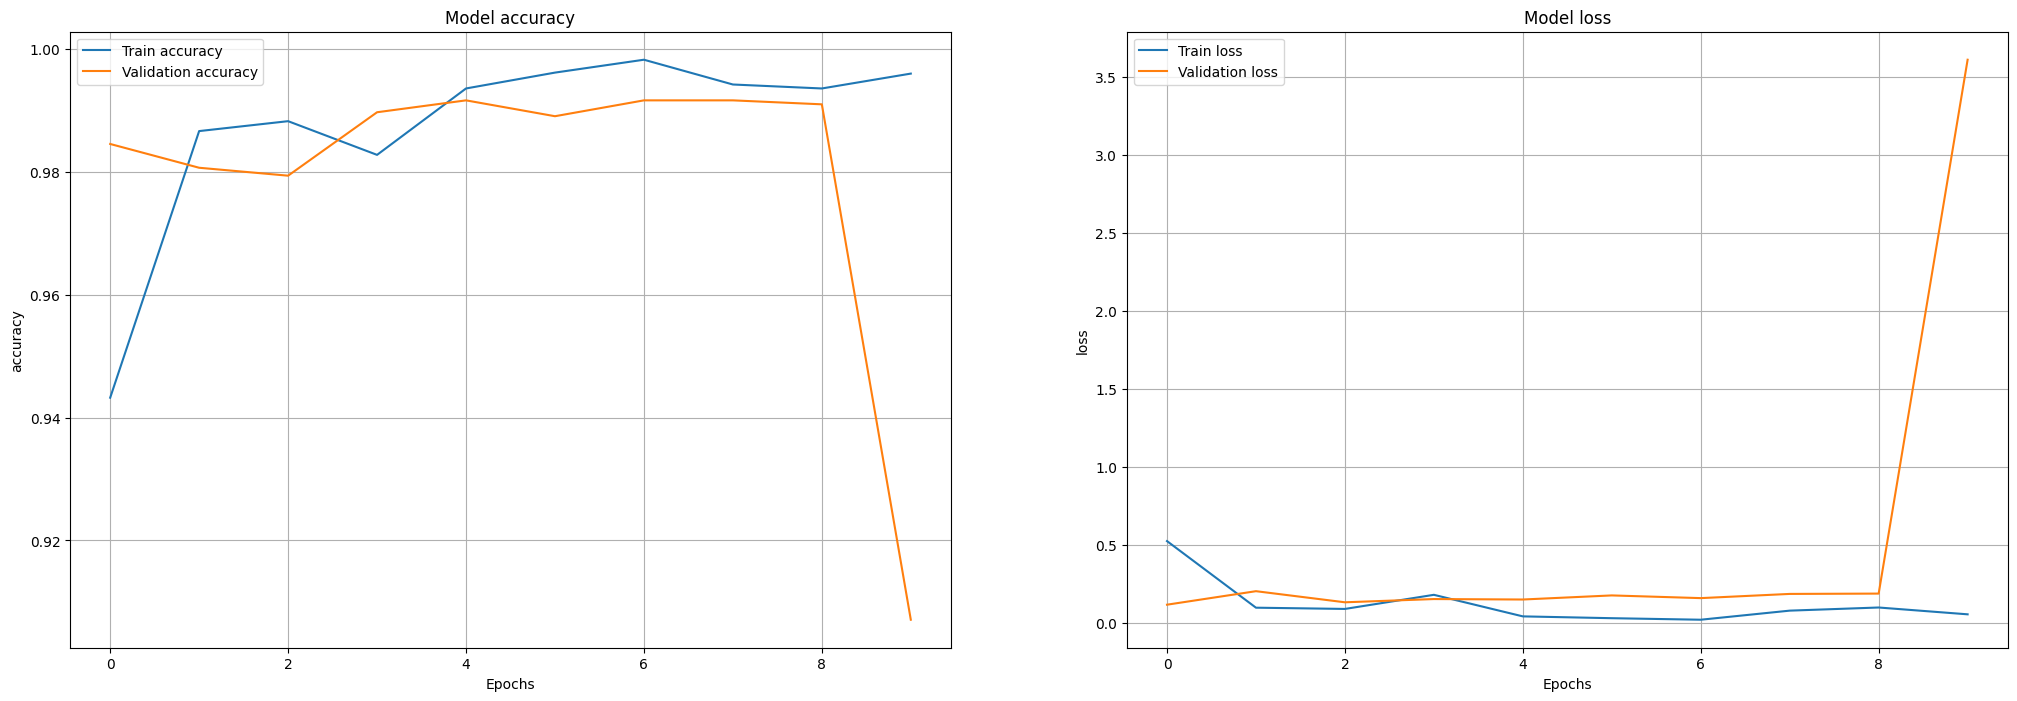

39/39 [==============================] - 4s 33ms/step - loss: 972.0903 - accuracy: 0.6250

Test accuracy: 0.625
39/39 [==============================] - 3s 30ms/step

Confusion Matrix:


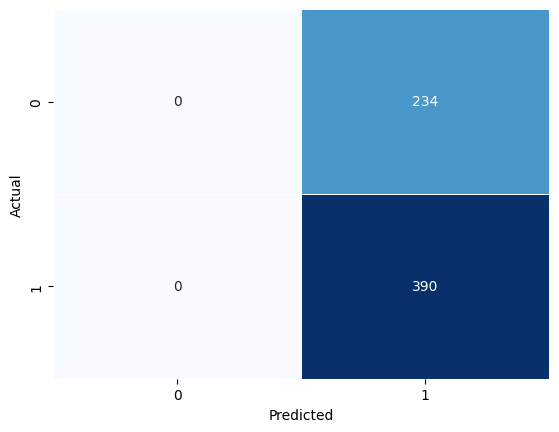


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# history_iv3 = iv3.fit(train_data, epochs=20,validation_data = val_data)
evaluate_model(model=iv3, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10, class_names=class_label)

### 3.3 EffientNetV2B3 

In [22]:
eff_v2 = efficientnet_v2.EfficientNetV2B3(include_top = False, weights = 'imagenet',input_shape = image_size)

for layer in eff_v2.layers:
    layer.trainable = False
    
x = Flatten()(eff_v2.output)
x = Dense(1, activation="sigmoid")(x)

eff_v2 = Model(inputs=eff_v2.input, outputs=x)
eff_v2.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

52606240/52606240 [==============================] - 1s 0us/step


Epoch 1/10


2023-04-06 09:41:12.179121: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


388/388 [==============================] - 32s 53ms/step - loss: 2.0773 - accuracy: 0.5184 - val_loss: 1.5428 - val_accuracy: 0.5077
Epoch 2/10
388/388 [==============================] - 17s 44ms/step - loss: 2.0607 - accuracy: 0.5468 - val_loss: 1.3815 - val_accuracy: 0.4961
Epoch 3/10
388/388 [==============================] - 17s 44ms/step - loss: 1.8835 - accuracy: 0.5569 - val_loss: 1.1368 - val_accuracy: 0.5084
Epoch 4/10
388/388 [==============================] - 17s 44ms/step - loss: 1.8275 - accuracy: 0.5671 - val_loss: 1.2398 - val_accuracy: 0.5071
Epoch 5/10
388/388 [==============================] - 17s 44ms/step - loss: 1.8022 - accuracy: 0.5652 - val_loss: 1.9422 - val_accuracy: 0.5077
Epoch 6/10
388/388 [==============================] - 19s 49ms/step - loss: 1.6356 - accuracy: 0.5910 - val_loss: 2.3475 - val_accuracy: 0.4968
Epoch 7/10
388/388 [==============================] - 17s 44ms/step - loss: 1.3364 - accuracy: 0.6076 - val_loss: 3.3319 - val_accuracy: 0.4961
Epo

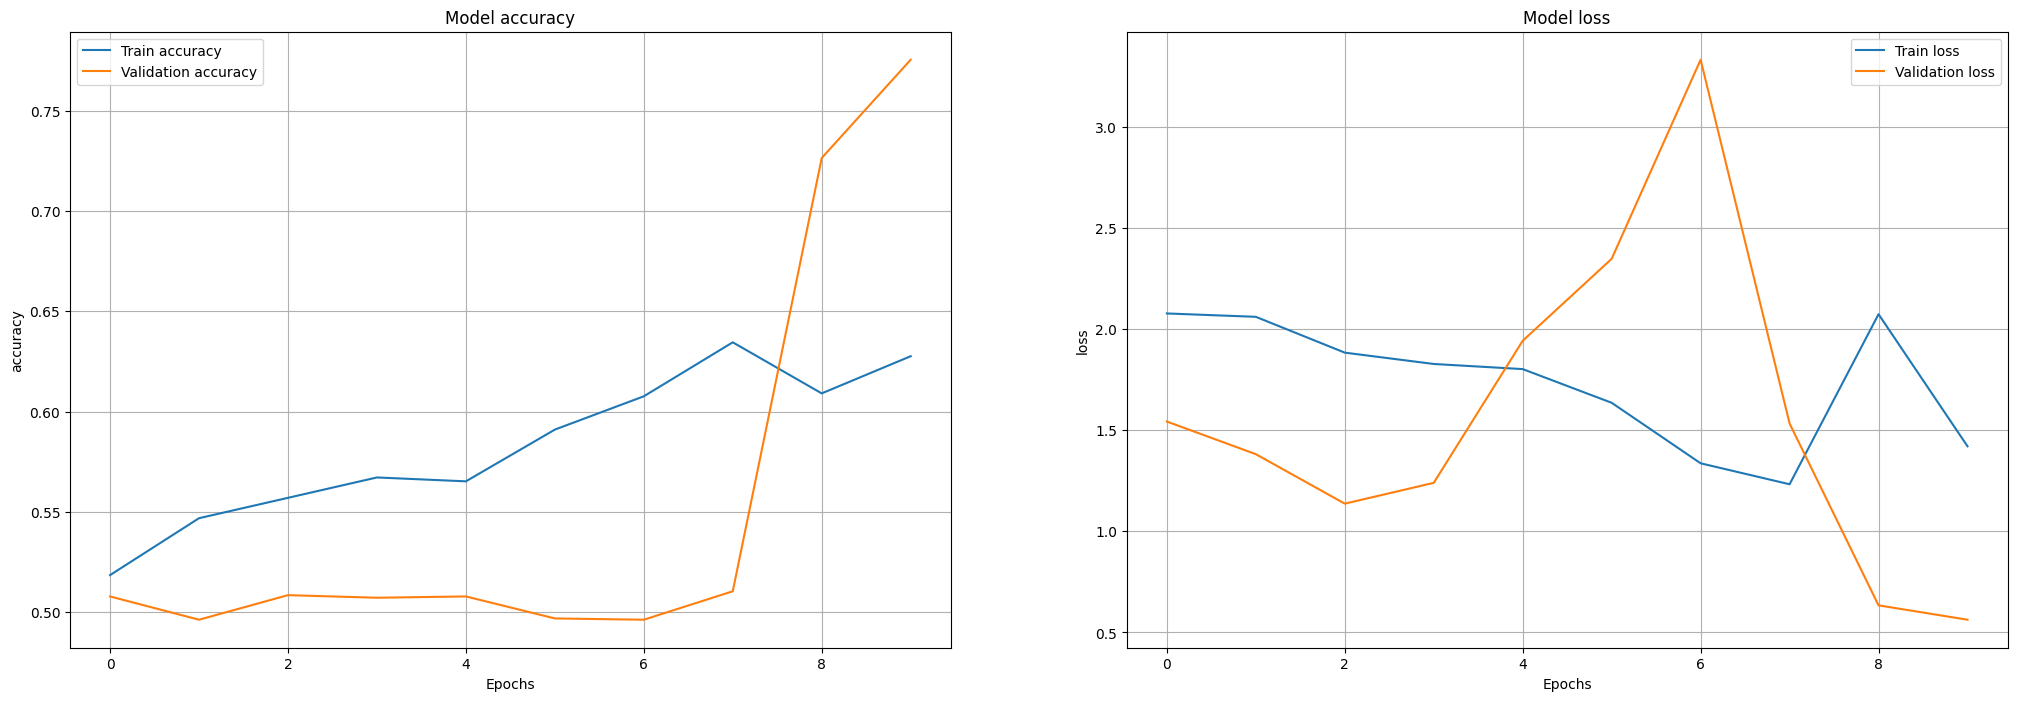

39/39 [==============================] - 4s 36ms/step - loss: 7.9947 - accuracy: 0.4087

Test accuracy: 0.4086538553237915
39/39 [==============================] - 4s 34ms/step

Confusion Matrix:


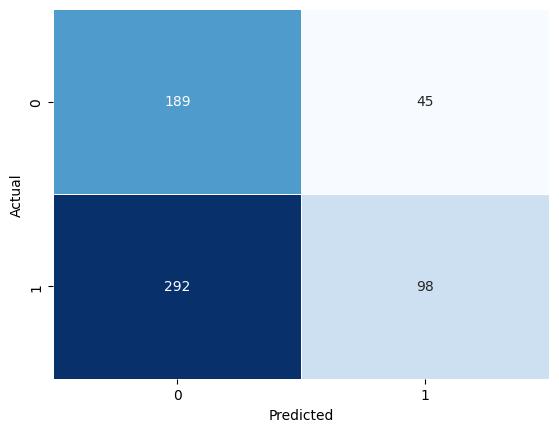


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.39      0.81      0.53       234
   PNEUMONIA       0.69      0.25      0.37       390

    accuracy                           0.46       624
   macro avg       0.54      0.53      0.45       624
weighted avg       0.58      0.46      0.43       624



In [23]:
# history_eff_v2 = eff_v2.fit(train_data, epochs=20,validation_data = val_data)
evaluate_model(model=eff_v2, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10, class_names=class_label)

## <b> 4. VGG-16 backbone with Attention heads </b>

### 4.1 Self-Attention

In [28]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

The `SelfAttention` class is a custom implementation of a self-attention mechanism, which is a simplified version of the multi-head attention mechanism. The self-attention mechanism allows the model to weigh the importance of different features in the input by attending to different parts of the input. Here's a breakdown of the `SelfAttention` class:

1. `__init__(self, d_k)`: The constructor takes a single argument `d_k`, which is the dimension of the key, query, and value vectors in the attention mechanism. It initializes the class by calling the base class constructor and storing the `d_k` value.

2. `build(self, input_shape)`: This method is called when the layer is added to the model, and it initializes the weight matrices for the key (WK), query (WQ), and value (WV) projections. The weight matrices are of shape `(input_shape[-1], self.d_k)` and are initialized using the Glorot uniform distribution.

3. `call(self, inputs)`: This method is called during the forward pass of the model when the layer processes the input data. It takes the input tensor and does the following:

   a. Computes the query (Q), key (K), and value (V) matrices by multiplying the input tensor with the corresponding weight matrices (WQ, WK, WV).
   
   b. Calculates the attention logits by computing the dot product of the query (Q) and key (K) matrices, and scales the result by the square root of `d_k` to avoid gradients becoming too small or too large.
   
   c. Applies the softmax function to the attention logits to obtain the attention weights, which represent the importance of each feature in the input.
   
   d. Computes the attention output by multiplying the attention weights with the value (V) matrix. This output is a weighted sum of the input features according to their attention weights.
   
The `SelfAttention` layer outputs the attention output, which can be fed to the next layer in the model. In our case, it is followed by the classification layer with a softmax activation function.

In [29]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_k):
        super(SelfAttention, self).__init__()
        self.d_k = d_k

    def build(self, input_shape):
        self.WQ = self.add_weight(name='WQ', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)
        self.WK = self.add_weight(name='WK', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)
        self.WV = self.add_weight(name='WV', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        Q = tf.linalg.matmul(inputs, self.WQ)
        K = tf.linalg.matmul(inputs, self.WK)
        V = tf.linalg.matmul(inputs, self.WV)
        attention_logits = tf.linalg.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.d_k, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        attention_output = tf.linalg.matmul(attention_weights, V)
        return attention_output

In [33]:
global_avg_pool = layers.GlobalAveragePooling2D()(base_model.output)
attention_output = SelfAttention(d_k=64)(global_avg_pool)
predictions = layers.Dense(1, activation='sigmoid')(attention_output)
model_selfAtt = Model(inputs=base_model.input, outputs=predictions)

model_selfAtt.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
388/388 [==============================] - 22s 51ms/step - loss: 0.6914 - accuracy: 0.5287 - val_loss: 0.6678 - val_accuracy: 0.7239
Epoch 2/10
388/388 [==============================] - 20s 51ms/step - loss: 0.5262 - accuracy: 0.8305 - val_loss: 0.3963 - val_accuracy: 0.8748
Epoch 3/10
388/388 [==============================] - 20s 51ms/step - loss: 0.3372 - accuracy: 0.8860 - val_loss: 0.3046 - val_accuracy: 0.8974
Epoch 4/10
388/388 [==============================] - 20s 51ms/step - loss: 0.2873 - accuracy: 0.8961 - val_loss: 0.2709 - val_accuracy: 0.8929
Epoch 5/10
388/388 [==============================] - 20s 51ms/step - loss: 0.2794 - accuracy: 0.9000 - val_loss: 0.2676 - val_accuracy: 0.8968
Epoch 6/10
388/388 [==============================] - 20s 51ms/step - loss: 0.2648 - accuracy: 0.9052 - val_loss: 0.2629 - val_accuracy: 0.9000
Epoch 7/10
388/388 [==============================] - 20s 51ms/step - loss: 0.2550 - accuracy: 0.9077 - val_loss: 0.2361 - val_accuracy:

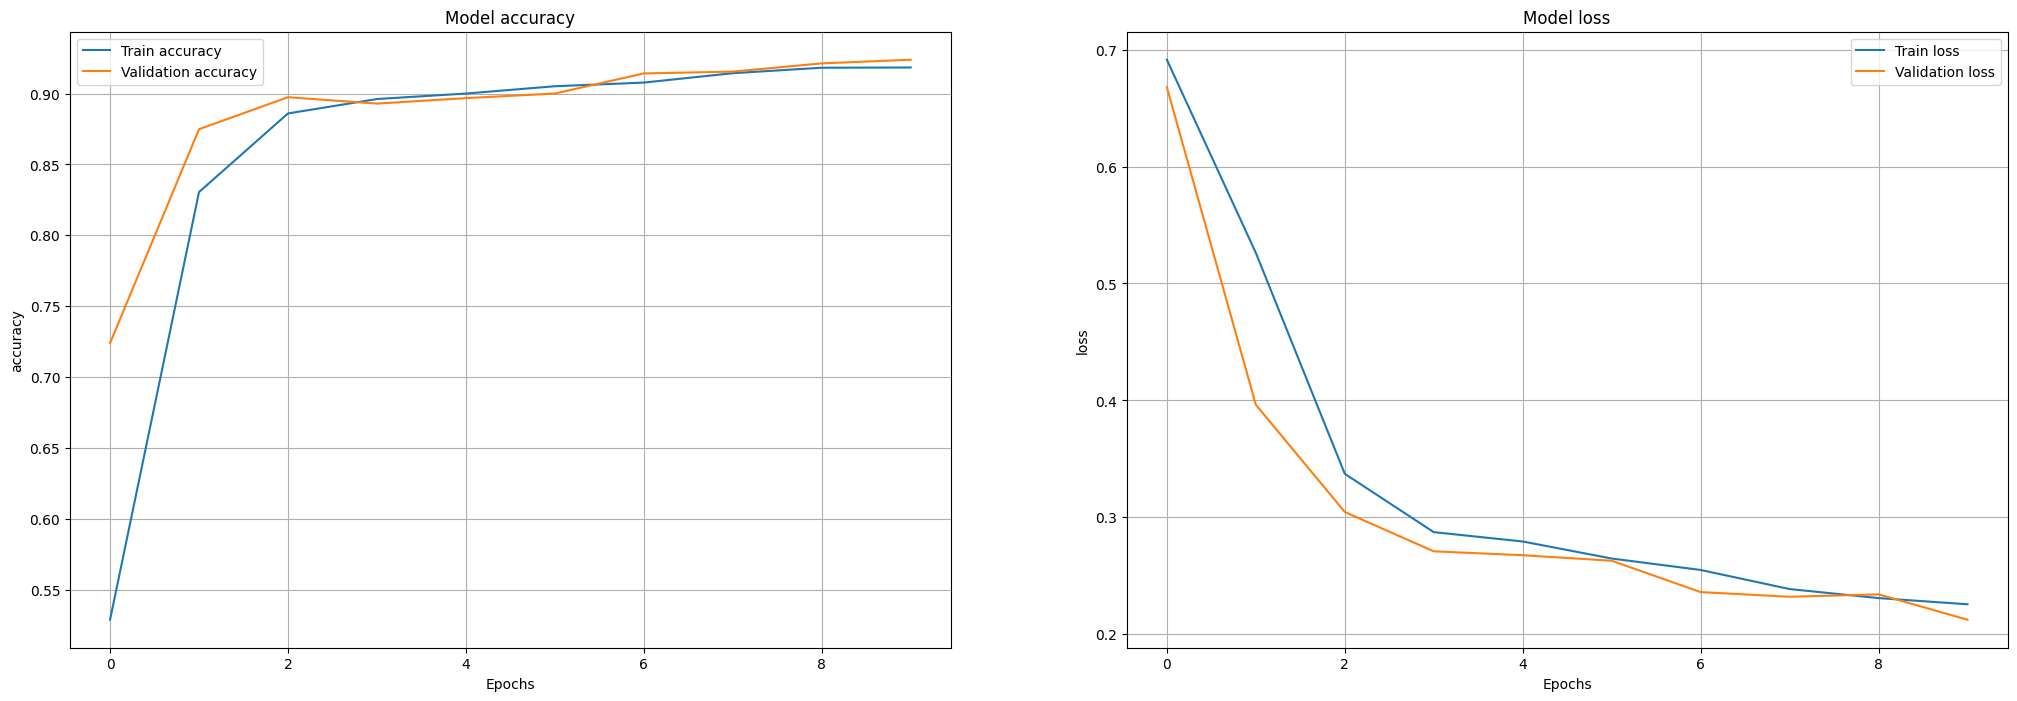

39/39 [==============================] - 2s 41ms/step - loss: 180.5881 - accuracy: 0.3750

Test accuracy: 0.375
39/39 [==============================] - 2s 39ms/step

Confusion Matrix:


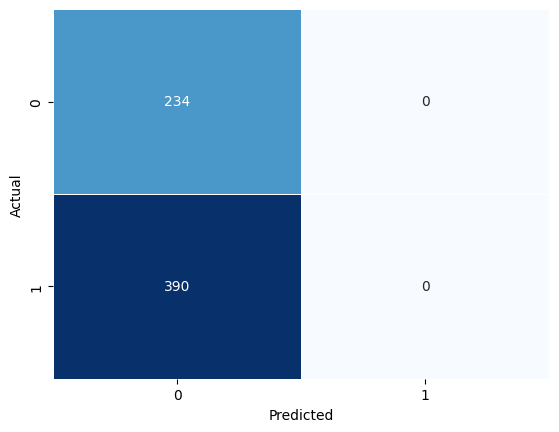


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
evaluate_model(model=model_selfAtt, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10, class_names=class_label)

### 4.2 MultiHead Attention

In [ ]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_k):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_k
        self.attention_heads = [SelfAttention(d_k=self.d_k) for _ in range(self.num_heads)]

    def call(self, inputs):
        attention_outputs = [head(inputs) for head in self.attention_heads]
        multihead_output = tf.concat(attention_outputs, axis=-1)
        return multihead_output

In [35]:
flatten_output = layers.Flatten()(base_model.output)
global_avg_pool = layers.GlobalAveragePooling1D()(flatten_output[:, None, :])
attention_output = MultiHeadSelfAttention(num_heads=2, d_k=64)(global_avg_pool)
flatten_attention_output = layers.Flatten()(attention_output)
predictions = layers.Dense(1, activation='sigmoid')(flatten_attention_output)
model_multHdAtt = Model(inputs=base_model.input, outputs=predictions)

model_multHdAtt.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
388/388 [==============================] - 23s 52ms/step - loss: 1.1590 - accuracy: 0.5039 - val_loss: 1.7074 - val_accuracy: 0.4897
Epoch 2/10
388/388 [==============================] - 20s 51ms/step - loss: 1.1585 - accuracy: 0.5147 - val_loss: 1.8798 - val_accuracy: 0.4935
Epoch 3/10
388/388 [==============================] - 20s 52ms/step - loss: 1.0960 - accuracy: 0.5063 - val_loss: 0.8970 - val_accuracy: 0.5000
Epoch 4/10
388/388 [==============================] - 21s 55ms/step - loss: 0.9572 - accuracy: 0.5121 - val_loss: 0.8382 - val_accuracy: 0.5084
Epoch 5/10
388/388 [==============================] - 20s 51ms/step - loss: 1.0026 - accuracy: 0.5060 - val_loss: 0.8038 - val_accuracy: 0.4968
Epoch 6/10
388/388 [==============================] - 20s 52ms/step - loss: 0.9340 - accuracy: 0.5069 - val_loss: 0.7478 - val_accuracy: 0.5058
Epoch 7/10
388/388 [==============================] - 20s 51ms/step - loss: 0.7380 - accuracy: 0.6287 - val_loss: 0.3277 - val_accuracy:

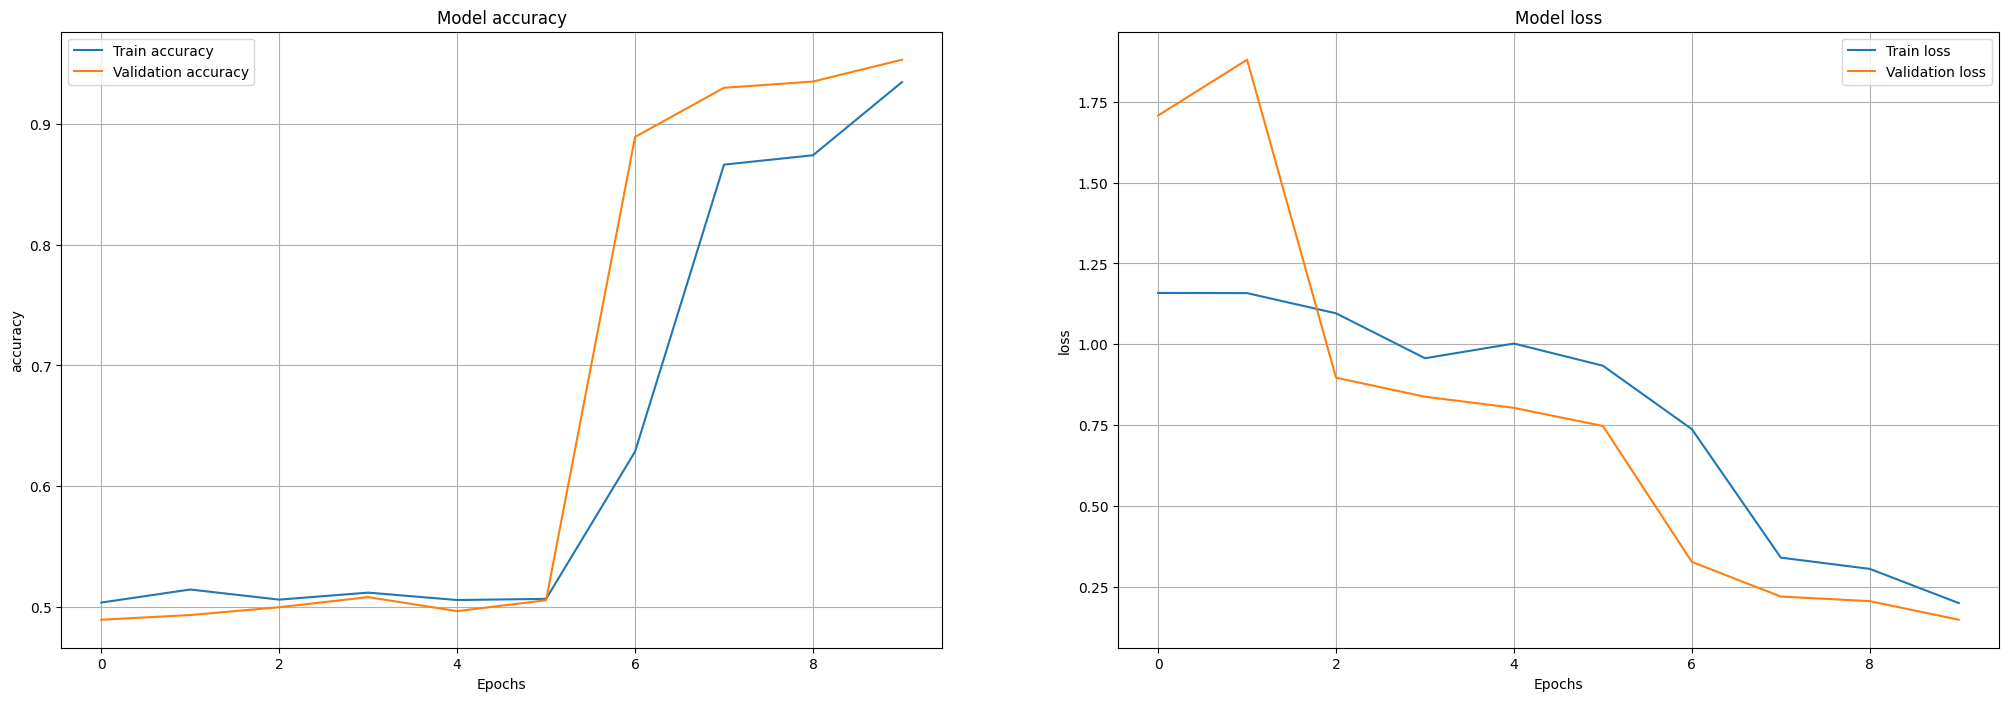

39/39 [==============================] - 2s 42ms/step - loss: 59.1442 - accuracy: 0.4135

Test accuracy: 0.4134615361690521
39/39 [==============================] - 2s 39ms/step

Confusion Matrix:


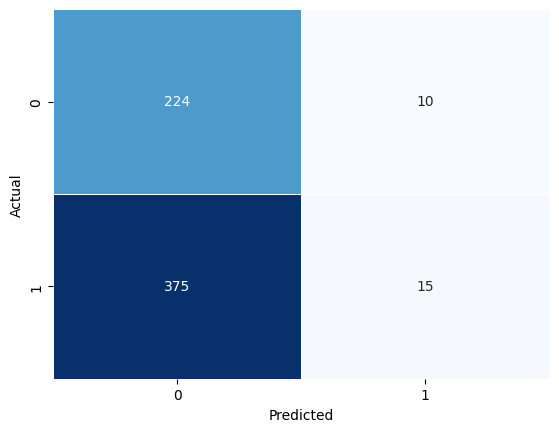


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.37      0.96      0.54       234
   PNEUMONIA       0.60      0.04      0.07       390

    accuracy                           0.38       624
   macro avg       0.49      0.50      0.31       624
weighted avg       0.52      0.38      0.25       624



In [36]:
evaluate_model(model=model_multHdAtt, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10, class_names=class_label)

## <b> 5. Visual Transformers (ViT) </b>

In [37]:
def create_vit_classifier():
    model = vit.vit_b32(
        image_size=img_height,
        activation='sigmoid',
        pretrained=True,
        include_top=True,
        pretrained_top=False,
        classes=1,
        weights='imagenet21k'
    )

    input_layer = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input_layer)  # Normalize the input images
    output = model(x)

    return tf.keras.Model(inputs=input_layer, outputs=output)

model_vit = create_vit_classifier()
model_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

419441810/419441810 [==============================] - 7s 0us/step


/opt/conda/envs/aasd4015/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 7, 7 to 10, 10
  warnings.warn(


Epoch 1/10
388/388 [==============================] - 106s 156ms/step - loss: 0.7107 - accuracy: 0.4977 - val_loss: 0.6936 - val_accuracy: 0.4935
Epoch 2/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6993 - accuracy: 0.4971 - val_loss: 0.6934 - val_accuracy: 0.4935
Epoch 3/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6987 - accuracy: 0.4937 - val_loss: 0.6952 - val_accuracy: 0.5065
Epoch 4/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6971 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5065
Epoch 5/10
388/388 [==============================] - 57s 147ms/step - loss: 0.6997 - accuracy: 0.4929 - val_loss: 0.6966 - val_accuracy: 0.4935
Epoch 6/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6956 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5065
Epoch 7/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6941 - accuracy: 0.5171 - val_loss: 0.6938 - val_a

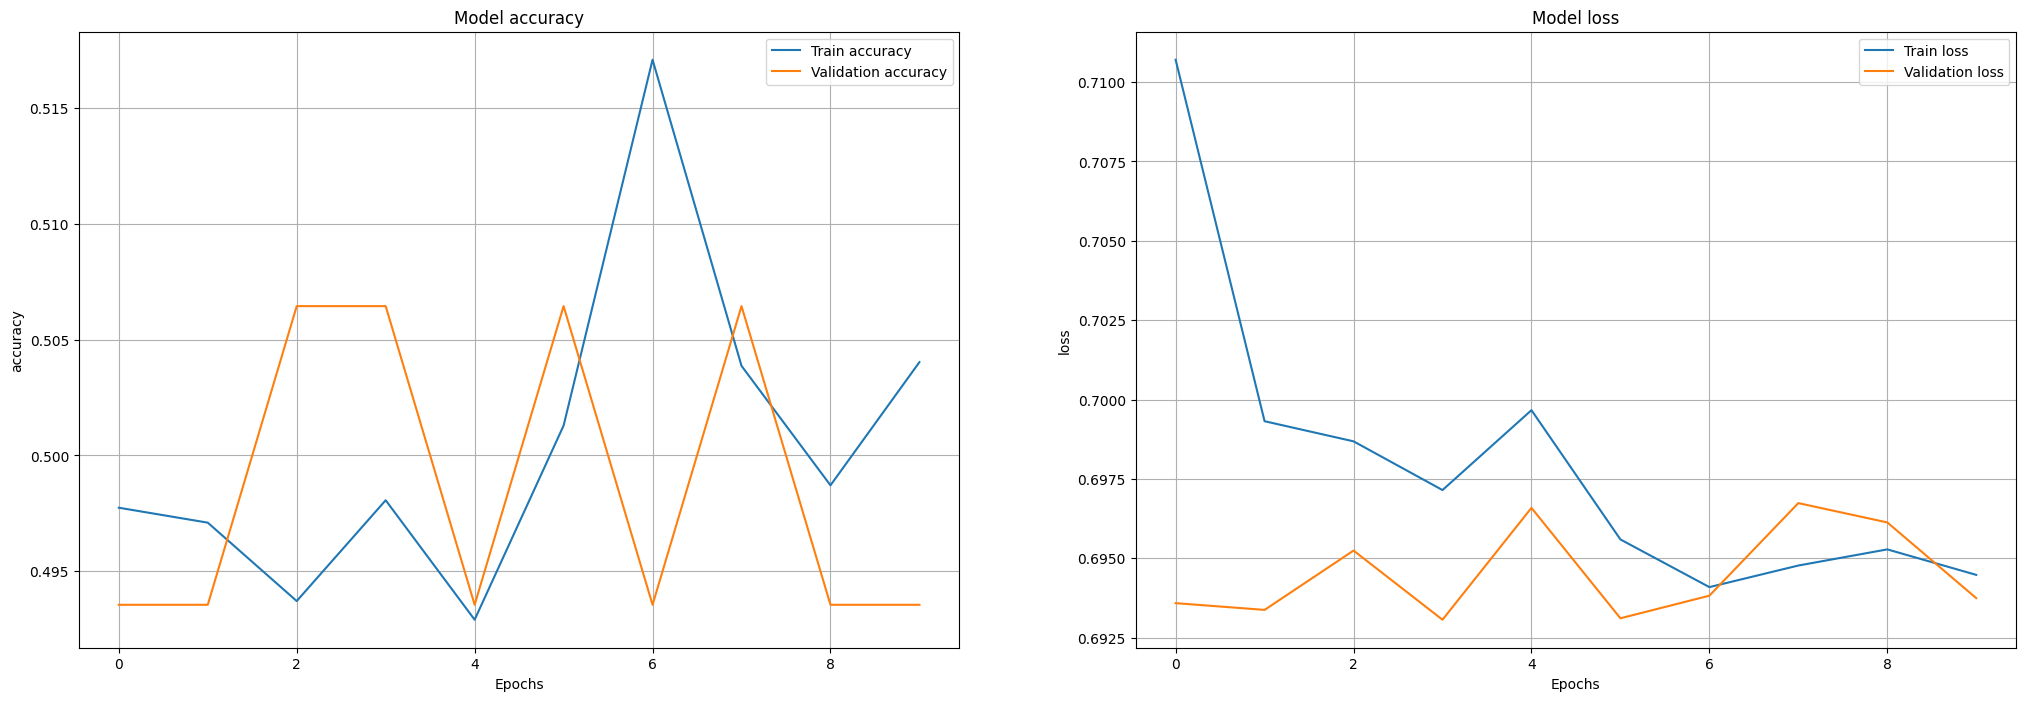

39/39 [==============================] - 6s 63ms/step - loss: 0.7002 - accuracy: 0.3750

Test accuracy: 0.375
39/39 [==============================] - 6s 62ms/step

Confusion Matrix:


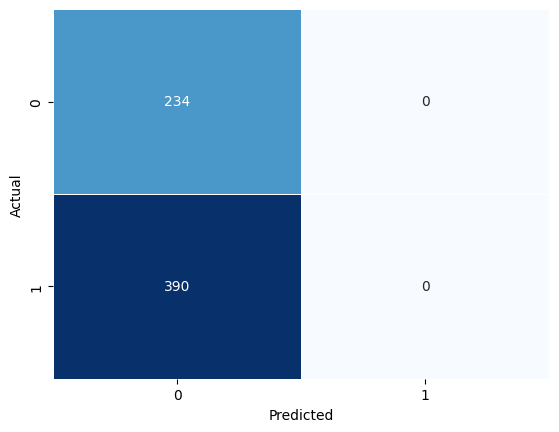


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/aasd4015/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
evaluate_model(model=model_vit, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10, class_names=class_label)

## <b> 6. Results </b>

## <b> 7. Conclusions </b>

## <b> 8. Learning Outcomes </b>

## <b> 9. Comments/Future Work </b>

## <b> 10. References </b>